Imagine you have a messy collection of handwritten digits. You want the computer to take those digits, compress them into some hidden "code" that captures the essence of each digit. And then take that code and recreate the digits, or even create some new ones. A VAE does exactly that, it learns a complex representation.

We may wander why "Variational"?
That's because instead of encoding an image into just one code, VAEs encode it into a **distribution**(mean and variance of a Gaussian). This makes the model probabilistic, allowing us to sample different codes, which inturn generates slightly different images.

### Core Architecture

VAEs in the high level form looks like two Neural Networks glues into one. It consists of an Encoder which takes an image as an input and outputs parameters of a distribution. So instead of a single vector we get a clous of possibilities. Then we have a Decoder which takes the latent vector as input and outputs the reconstructed image.



In [2]:
import numpy as np
import math

import torchvision.transforms as transforms

from torchvision import datasets

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(28*28, 128)
        self.fc21 = nn.Linear(128, 64)   #Mean
        self.fc22 = nn.Linear(128, 64)   #log Variance


        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 28*28)


    def encoder(self, x):
      h = F.relu(self.fc1(x))
      mu = self.fc21(h)
      log_var = self.fc22(h)

      return mu, log_var

    def reparameterize(self, mu, log_var):
      std = torch.exp(0.5*log_var)
      eps = torch.randn_like(std)         #e ~ N(0,1)

      return mu + eps*std                 #reparameterization trick


    def decoder(self, z):
      h = F.relu(self.fc3(z))
      return torch.sigmoid(self.fc4(h))


    def forward(self, x):
        x = x.view(-1, 28*28) #flatten
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)

        return out, mu, logvar

In [4]:
def show_images(images, labels):
    """
    Display a batch of MNIST images with labels.
    """
    fig, axs = plt.subplots(1, len(images), figsize=(10, 2))
    if len(images) == 1:
        axs = [axs]  # make iterable
    for i, ax in enumerate(axs):
        ax.imshow(images[i].squeeze(), cmap="gray")
        ax.set_title(f"Label: {labels[i]}")
        ax.axis("off")
    plt.show()

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
learning_rate = 1e-3
num_epochs = 50

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss
    x = x.view(-1, 28*28)
    recon_x = recon_x.view(-1, 28*28)

    recon_loss = F.binary_cross_entropy(
        recon_x.view(-1, 28*28),
        x.view(-1, 28*28),
        reduction='sum'
    )

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss


Epoch 1/50: loss=124.5624


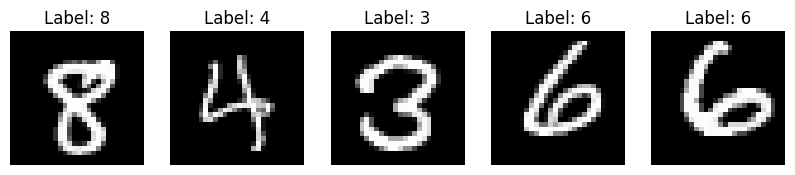

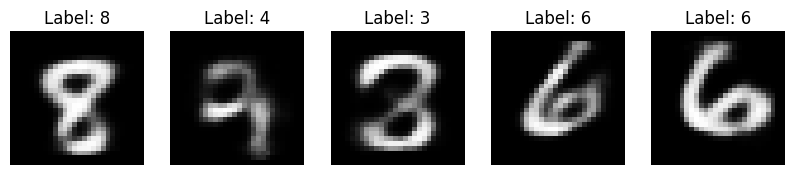

Epoch 2/50: loss=119.7918
Epoch 3/50: loss=117.1580
Epoch 4/50: loss=115.3410
Epoch 5/50: loss=113.9641
Epoch 6/50: loss=113.1018


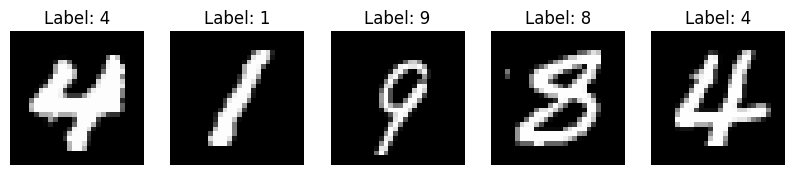

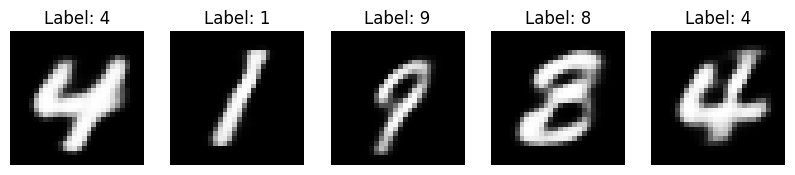

Epoch 7/50: loss=112.3040
Epoch 8/50: loss=111.7841
Epoch 9/50: loss=111.2711
Epoch 10/50: loss=110.8718
Epoch 11/50: loss=110.5964


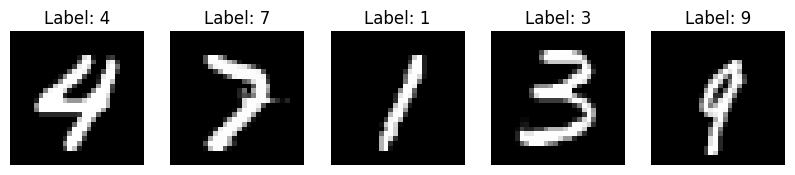

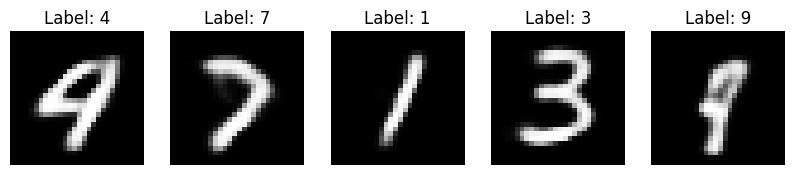

Epoch 12/50: loss=110.2138
Epoch 13/50: loss=109.9977
Epoch 14/50: loss=109.6882
Epoch 15/50: loss=109.5869
Epoch 16/50: loss=109.4059


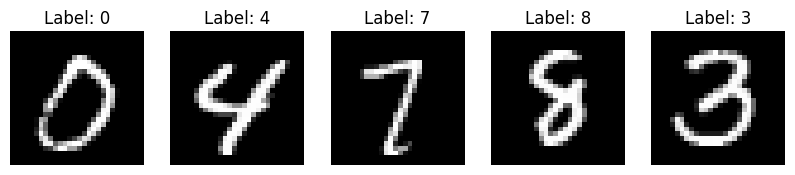

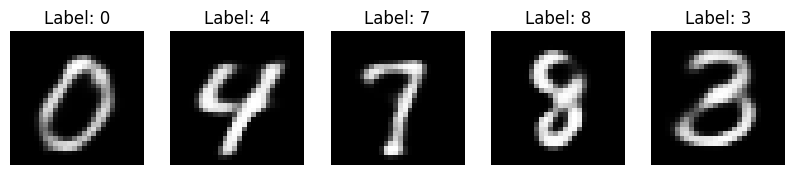

Epoch 17/50: loss=109.2113
Epoch 18/50: loss=109.0012
Epoch 19/50: loss=108.9093
Epoch 20/50: loss=108.7566
Epoch 21/50: loss=108.6260


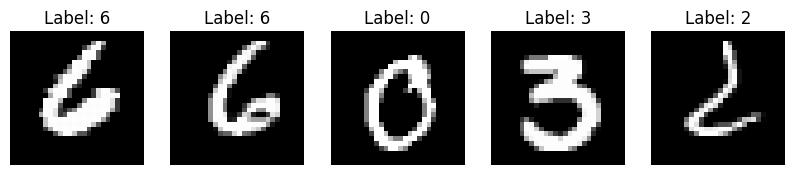

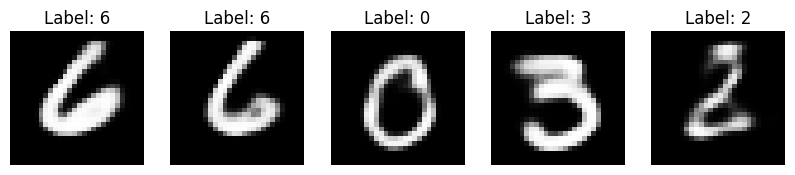

Epoch 22/50: loss=108.5170
Epoch 23/50: loss=108.3752
Epoch 24/50: loss=108.2492
Epoch 25/50: loss=108.1188
Epoch 26/50: loss=108.0964


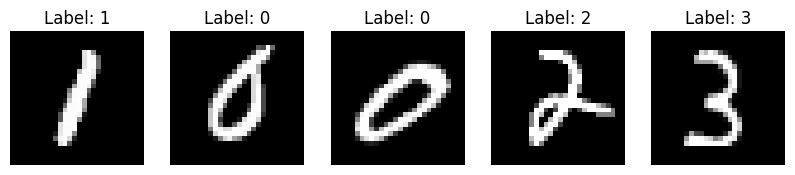

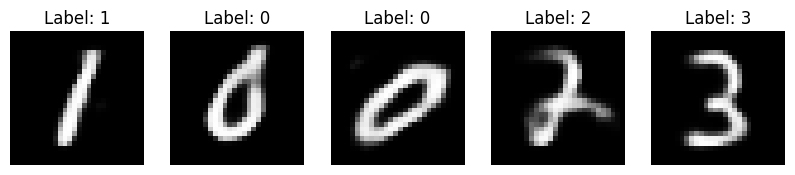

Epoch 27/50: loss=107.9712
Epoch 28/50: loss=107.9014
Epoch 29/50: loss=107.8406
Epoch 30/50: loss=107.7584
Epoch 31/50: loss=107.6504


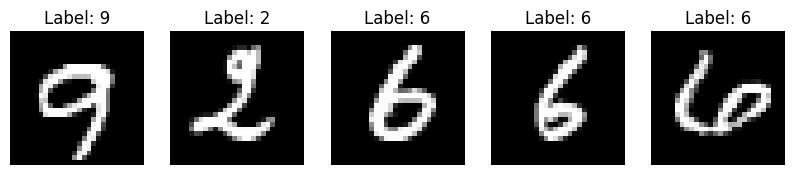

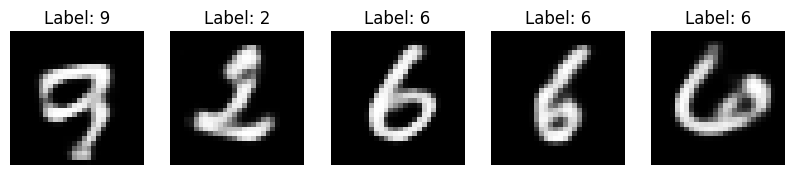

Epoch 32/50: loss=107.6136
Epoch 33/50: loss=107.5635
Epoch 34/50: loss=107.4587
Epoch 35/50: loss=107.4246
Epoch 36/50: loss=107.3762


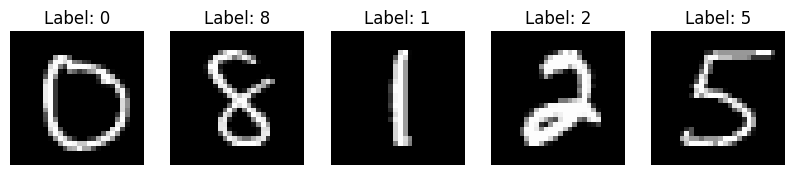

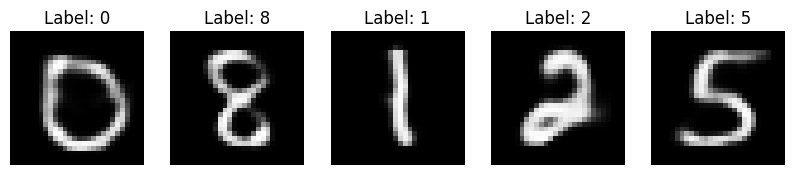

Epoch 37/50: loss=107.3167
Epoch 38/50: loss=107.2810
Epoch 39/50: loss=107.2210
Epoch 40/50: loss=107.1798
Epoch 41/50: loss=107.1890


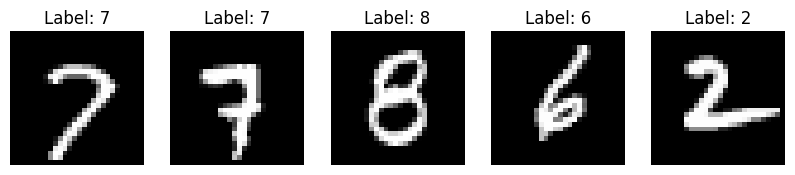

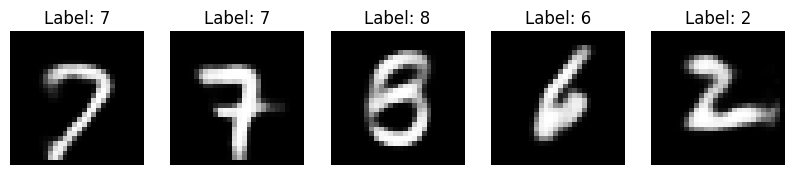

Epoch 42/50: loss=107.1384
Epoch 43/50: loss=107.0363
Epoch 44/50: loss=107.0559
Epoch 45/50: loss=106.9729
Epoch 46/50: loss=106.9459


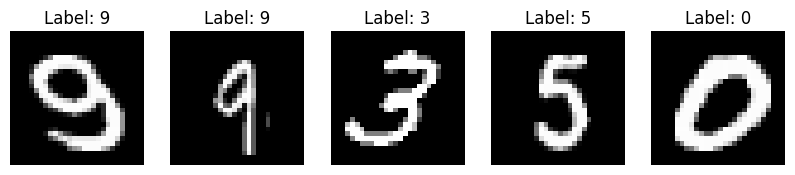

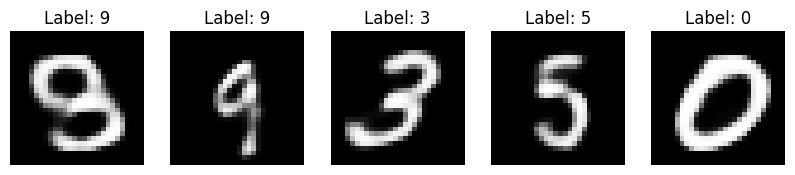

Epoch 47/50: loss=106.8539
Epoch 48/50: loss=106.8308
Epoch 49/50: loss=106.8482
Epoch 50/50: loss=106.7505


In [ ]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device).float()

        # Forward
        recon_x, mu, logvar = model(images)
        
        loss = vae_loss(recon_x, images, mu, logvar) #VAE loss

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    epoch_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}: loss={epoch_loss:.4f}")

    # Show reconstructions every 5 epochs
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            sample_images, sample_labels = next(iter(train_loader))
            sample_images = sample_images.to(device)

            recon_x, mu, logvar = model(sample_images)

        show_images(sample_images.cpu()[:5], sample_labels[:5])
        show_images(recon_x.view(-1, 1, 28, 28).cpu()[:5], sample_labels[:5])
        model.train()



### First Task

1. **Pick 10 pairs of MNIST test images**

   * Each pair should be of the *same digit* (e.g., two different "7"s).
   * So we’ll have 10 rows, one for each pair.

2. **Encode both images in the pair**

   * Use the encoder part of the model.
   * This gives us two latent codes: z1 and z2.

3. **Interpolate between the codes**

  * Linearly interpolate from \(z_1\) to \(z_2\).  
  * Instead of jumping directly, we generate 7 evenly spaced steps:

$$
z_\alpha = (1 - \alpha) z_1 + \alpha z_2, \quad \alpha \in \left\{ \frac{1}{8}, \frac{2}{8}, \dots, \frac{7}{8} \right\}
$$

  * So including the originals, each row has:

     z1 → interpolate_1 → interpolate_2 → ... → interpolate_7 → z2
     
     \= 9 images in total.

4. **Decode all codes back into images**

   * Feed each interpolated latent code (and the originals) into the decoder.
   * This gives us images that “morph” gradually from the first test image to the second.

5. **Arrange into a figure**

   * Each row = 1 pair of digits morphing.
   * Each row has 9 images (the two originals + 7 in-between).
   * The final figure = 10 rows × 9 columns.


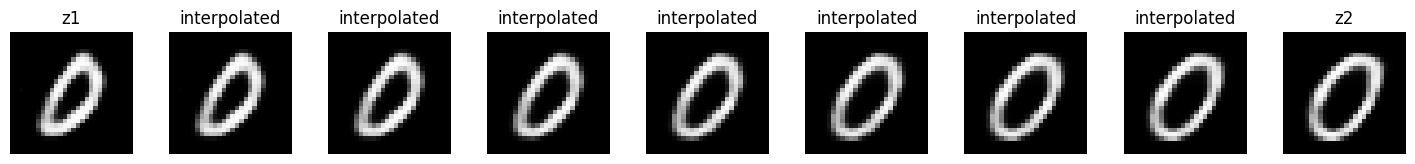

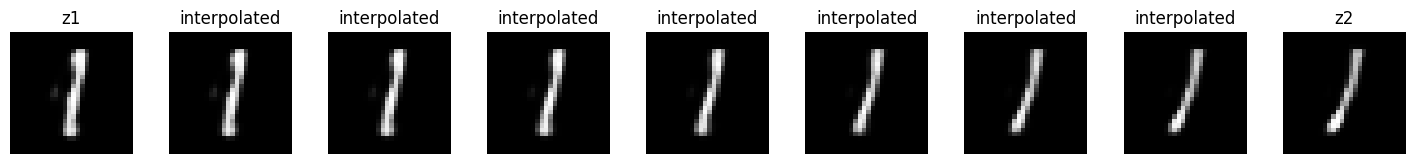

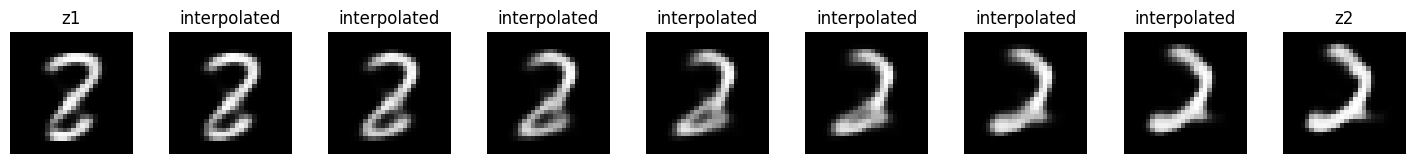

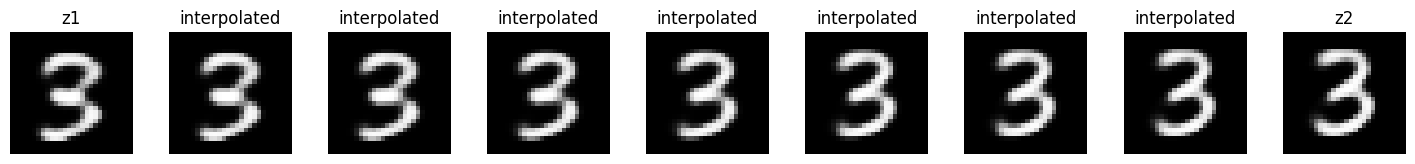

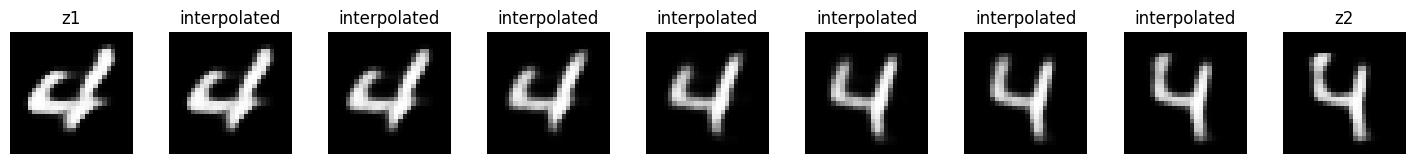

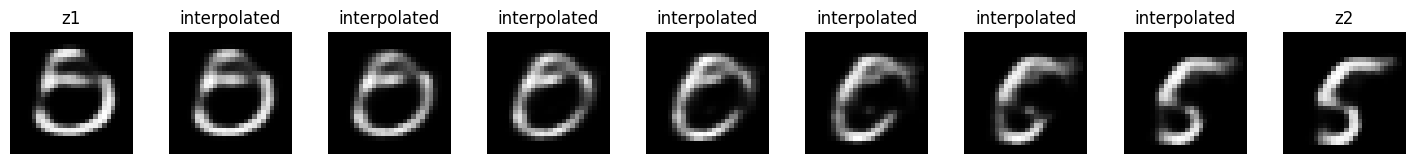

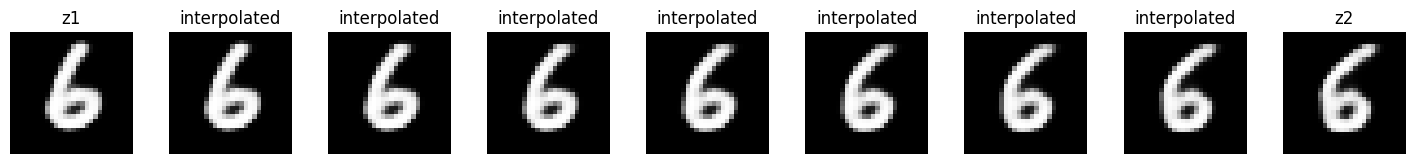

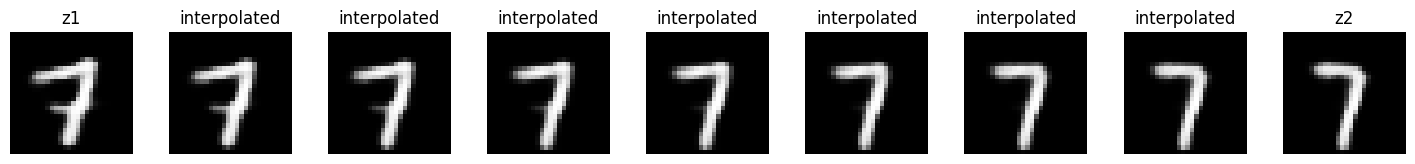

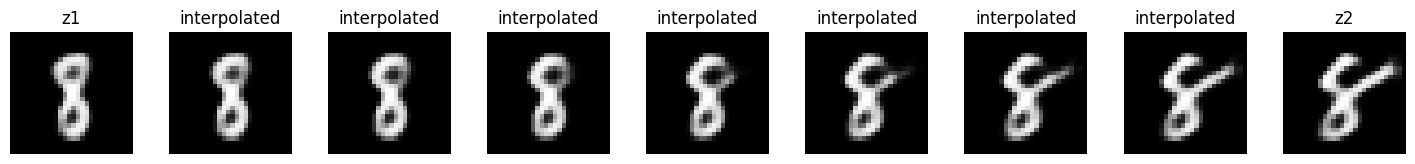

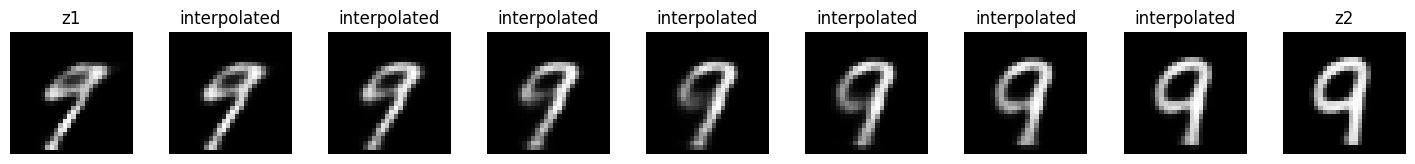

In [ ]:
import random

pairs = []
for digit in range(10):  # one pair for each digit
    indices = (test_dataset.targets == digit).nonzero(as_tuple=True)[0]

    i1, i2 = random.sample(indices.tolist(), 2)

    # Get the actual images
    img1, _ = test_dataset[i1]
    img2, _ = test_dataset[i2]

    pairs.append((img1, img2))

alphas = torch.linspace(0, 1, steps=9)[1:-1]

interpolated_alpha = []

for (img1,img2) in pairs:
    images = images.to(device)

    # Forward
    mu1, logvar1 = model.encoder(img1.view(1, -1).to(device))
    mu2, logvar2 = model.encoder(img2.view(1, -1).to(device))

    # Sampling z from the latent distributions
    z1 = model.reparameterize(mu1, logvar1)
    z2 = model.reparameterize(mu2, logvar2)


    row = []
    row.append(model.decoder(z1).view(1, 1, 28, 28))  # first image

    for alpha in alphas:
        z_alpha = (1 - alpha) * z1 + alpha * z2
        decoded = model.decoder(z_alpha).view(1, 1, 28, 28)
        row.append(decoded)


    row.append(model.decoder(z2).view(1, 1, 28, 28))  # last image


    def show_images(images, labels):
        num_images = len(images)

        fig, axs = plt.subplots(1, num_images, figsize=(2 * num_images, 2))
        if num_images == 1:
            axs = [axs]
        for i, ax in enumerate(axs):
            ax.imshow(images[i].squeeze(), cmap="gray")
            ax.set_title(f"{labels[i]}")
            ax.axis("off")

        plt.subplots_adjust(wspace=0.3)
        plt.show()

    batch_np = []
    for img in row:
        img_np = img.detach().cpu().numpy()

        if img_np.shape == (784,):
            img_np = img_np.reshape(28, 28)
        elif img_np.shape == (1, 28, 28) or img_np.shape == (1, 1, 28, 28):
            img_np = img_np.squeeze()
        elif img_np.shape == (1, 1, 784) or img_np.shape == (1, 784):
            img_np = img_np.reshape(28, 28)
        elif img_np.shape == (28, 28):
            pass
        else:
            raise ValueError(f"Unexpected image shape: {img_np.shape}")

        batch_np.append(img_np)


    batch_np = np.array(batch_np)
    num_images = len(batch_np)
    labels = ["interpolated"] * num_images
    if num_images > 0:
        labels[0] = "z1"
    if num_images > 1:
        labels[-1] = "z2"

    show_images(batch_np, labels=labels)



### Second Task

1. **Pick 10 pairs of MNIST test images**

   * Each pair should be of the *different digit* (e.g., one for "1"'s, another for "7"'s).
   * So we’ll have 10 rows, one for each pair.

2. **Encode both images in the pair**

   * Use the encoder part of the model.
   * This gives us two latent codes: z1 and z2.

3. **Interpolate between the codes**

  * Linearly interpolate from \(z_1\) to \(z_2\).  
  * Instead of jumping directly, we generate 7 evenly spaced steps:

$$
z_\alpha = (1 - \alpha) z_1 + \alpha z_2, \quad \alpha \in \left\{ \frac{1}{8}, \frac{2}{8}, \dots, \frac{7}{8} \right\}
$$

  * So including the originals, each row has:

     z1 → interpolate_1 → interpolate_2 → ... → interpolate_7 → z2
     
     \= 9 images in total.

4. **Decode all codes back into images**

   * Feed each interpolated latent code (and the originals) into the decoder.
   * This gives us images that “morph” gradually from the first test image to the second.

5. **Arrange into a figure**

   * Each row = 1 pair of digits morphing.
   * Each row has 9 images (the two originals + 7 in-between).
   * The final figure = 10 rows × 9 columns.


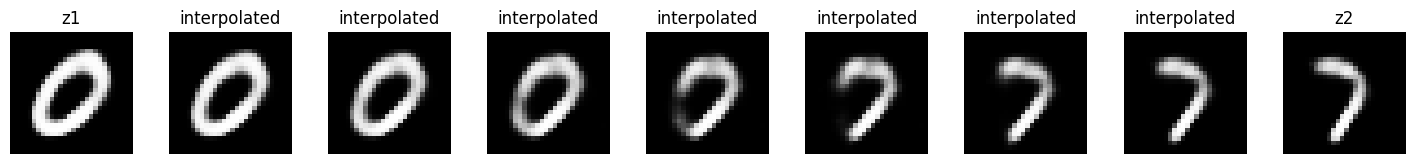

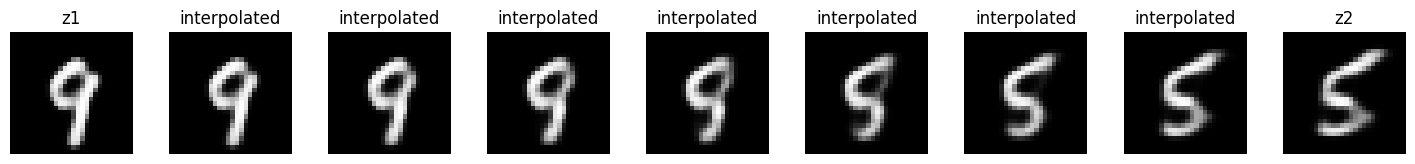

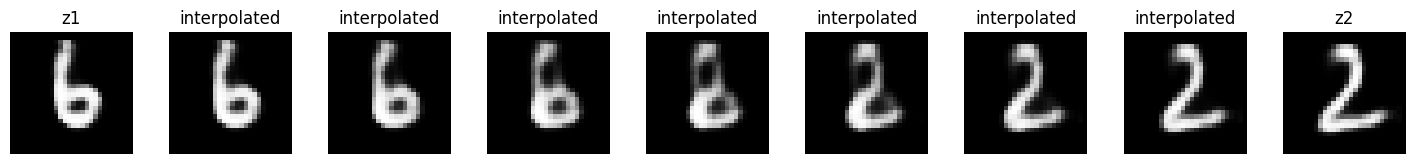

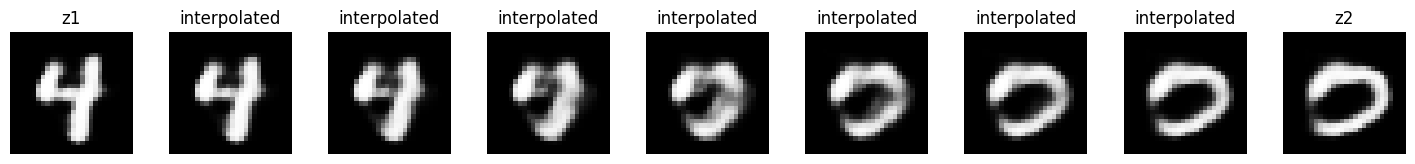

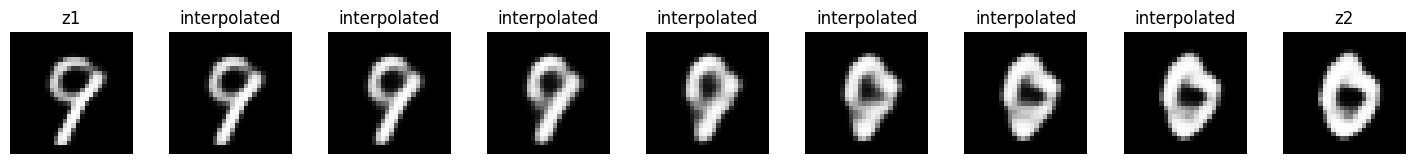

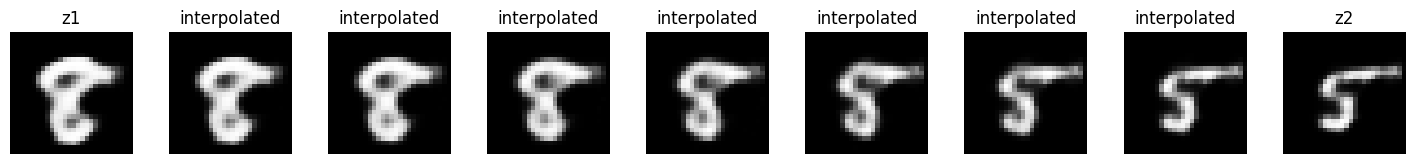

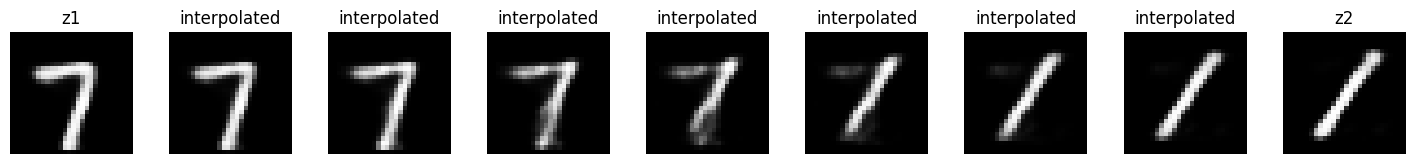

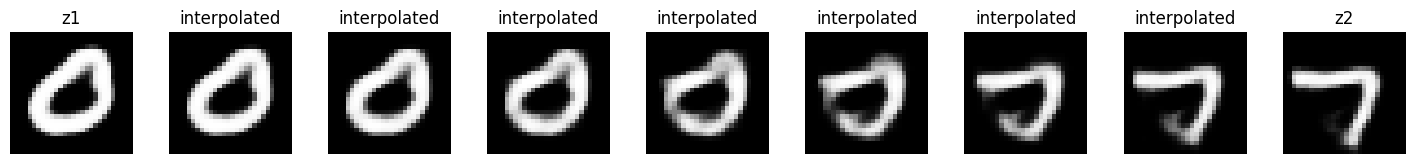

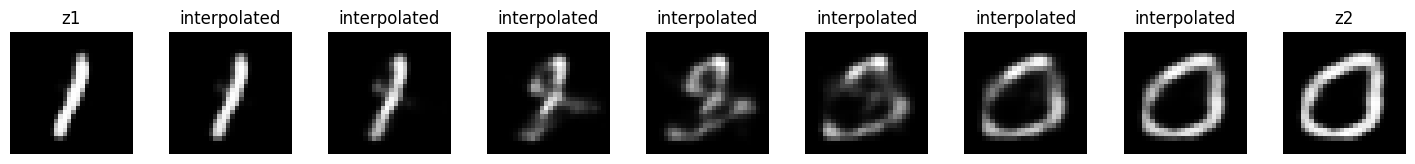

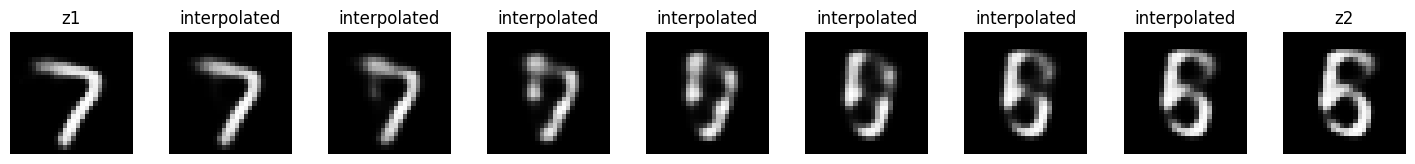

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

pairs = []
digits = list(range(10))

while len(pairs) < 10:
    digit1, digit2 = random.sample(digits, 2)  # ensures different labels
    indices1 = (test_dataset.targets == digit1).nonzero(as_tuple=True)[0]
    indices2 = (test_dataset.targets == digit2).nonzero(as_tuple=True)[0]
    i1 = random.choice(indices1.tolist())
    i2 = random.choice(indices2.tolist())
    img1, _ = test_dataset[i1]
    img2, _ = test_dataset[i2]
    pairs.append((img1, img2))



alphas = torch.linspace(0, 1, steps=9)[1:-1]

interpolated_alpha = []

for (img1,img2) in pairs:
    images = images.to(device)

    # Forward
    mu1, logvar1 = model.encoder(img1.view(1, -1).to(device))
    mu2, logvar2 = model.encoder(img2.view(1, -1).to(device))

    # Sampling z from the latent distributions
    z1 = model.reparameterize(mu1, logvar1)
    z2 = model.reparameterize(mu2, logvar2)


    row = []
    row.append(model.decoder(z1).view(1, 1, 28, 28))  # first image

    for alpha in alphas:
        z_alpha = (1 - alpha) * z1 + alpha * z2
        decoded = model.decoder(z_alpha).view(1, 1, 28, 28)
        row.append(decoded)


    row.append(model.decoder(z2).view(1, 1, 28, 28))  # last image


    def show_images(images, labels):
        num_images = len(images)

        fig, axs = plt.subplots(1, num_images, figsize=(2 * num_images, 2))
        if num_images == 1:
            axs = [axs]
        for i, ax in enumerate(axs):
            ax.imshow(images[i].squeeze(), cmap="gray")
            ax.set_title(f"{labels[i]}")
            ax.axis("off")

        plt.subplots_adjust(wspace=0.3)
        plt.show()

    batch_np = []
    for img in row:
        img_np = img.detach().cpu().numpy()

        if img_np.shape == (784,):
            img_np = img_np.reshape(28, 28)
        elif img_np.shape == (1, 28, 28) or img_np.shape == (1, 1, 28, 28):
            img_np = img_np.squeeze()
        elif img_np.shape == (1, 1, 784) or img_np.shape == (1, 784):
            img_np = img_np.reshape(28, 28)
        elif img_np.shape == (28, 28):
            pass
        else:
            raise ValueError(f"Unexpected image shape: {img_np.shape}")

        batch_np.append(img_np)


    batch_np = np.array(batch_np)
    num_images = len(batch_np)
    labels = ["interpolated"] * num_images
    if num_images > 0:
        labels[0] = "z1"
    if num_images > 1:
        labels[-1] = "z2"

    show_images(batch_np, labels=labels)